# Testing and Training Model Using Only ORD Flights

### This notebook takes the cleaned dataset (log_cleaned.csv) to train and test the model.  It then calculates mean absolute error and R² to determine how well the model is able to predict flight times.

## Step 1: Load Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load Data

This step loads the data in the csv file and makes all of the column headings lower case.  There were several errors when using sentence case headings, so this eliminates that problem.

In [2]:
# Load and filter dataset
df = pd.read_csv("log_cleaned.csv")
df.columns = df.columns.str.strip().str.lower()

# Keep only flights where ORD is origin or destination
df = df[(df['from iata code'] == 'ORD') | (df['to iata code'] == 'ORD')]

# Convert 'duration' to minutes from HH:MM
df['duration'] = pd.to_datetime(df['duration'], format='%H:%M').dt.hour * 60 + \
                 pd.to_datetime(df['duration'], format='%H:%M').dt.minute

## Step 3: Conversion of times to Minutes 

This step coverts the raw data for the duration from hours and minutes into minutes. 

In [3]:
# Convert departure time to minute of day
df['depminuteofday'] = (
    pd.to_datetime(df['dep time'], format='%H:%M').dt.hour * 60 +
    pd.to_datetime(df['dep time'], format='%H:%M').dt.minute
)

## Step 4: Encode Data

In [4]:
# One-hot encode categorical variables
categorical_cols = ['from iata code', 'to iata code', 'aircraft']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Combine features
X = pd.concat([df[['distance', 'depminuteofday']].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
y = df['duration']

## Step 5:  Train Test Split

This separates the data into train (80%) and test (20%).

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 6:  Random Forest Prediction

This step uses the RandomForestRegressor to train the model and then predict times.  It calculates and displays the MAE and R-squared

In [6]:
# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f} minutes")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error: 5.42 minutes
R² Score: 0.97


## Step 6: Sample of Predictions with Errors

This step shows 10 of the predictions to gauge how close the predictions are to actual.

In [7]:
# Results table with route info
results_df = pd.DataFrame({
    'From': df.iloc[X_test.index]['from iata code'].values,
    'To': df.iloc[X_test.index]['to iata code'].values,
    'Distance': df.iloc[X_test.index]['distance'].values,
    'Actual Duration': y_test.values,
    'Predicted Duration': y_pred
})

results_df['Absolute Error'] = (results_df['Actual Duration'] - results_df['Predicted Duration']).abs()
results_df = results_df.round(2)

# Print sample of results
print("\n📋 Sample of predictions:")
print(results_df.head(10))


📋 Sample of predictions:
  From   To  Distance  Actual Duration  Predicted Duration  Absolute Error
0  ORD  OKC       693               94              101.77            7.77
1  ATW  ORD       161               41               36.21            4.79
2  MSP  ORD       334               49               55.39            6.39
3  ORD  LSE       215               42               44.45            2.45
4  MSP  ORD       334               53               51.31            1.69
5  LSE  ORD       215               40               47.50            7.50
6  ORD  CAK       343               49               53.65            4.65
7  MKE  ORD        67               23               25.69            2.69
8  LSE  ORD       215               40               43.32            3.32
9  MSY  ORD       839              116              116.49            0.49


## Step 7: Visualization

This step shows a visualization of the data against actual times.

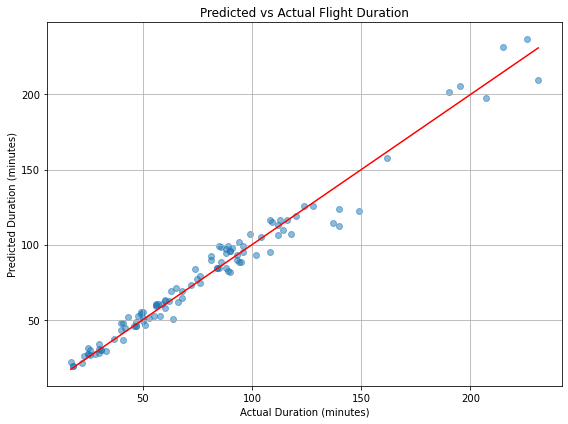

In [8]:
# Plot predictions vs. actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Duration (minutes)")
plt.ylabel("Predicted Duration (minutes)")
plt.title("Predicted vs Actual Flight Duration")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.grid(True)
plt.tight_layout()
plt.show()

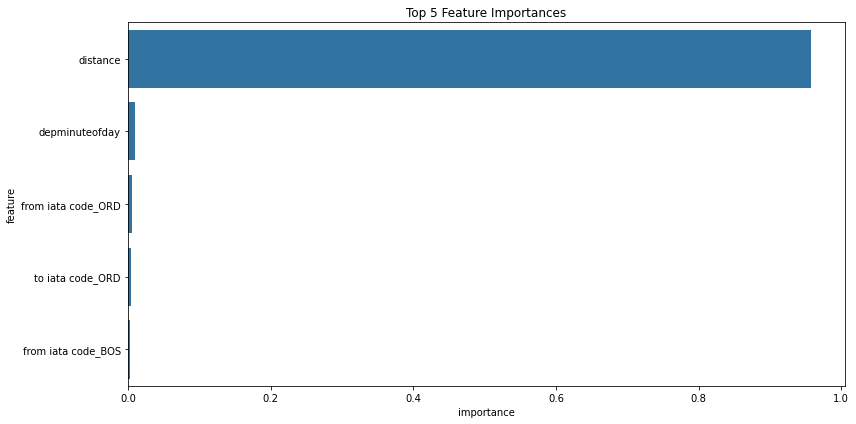

In [9]:
# Feature importance plot
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(5))
plt.title("Top 5 Feature Importances")
plt.tight_layout()
plt.show()

In [10]:
importances = model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False).head(5)

,Feature,Importance
0,distance,0.957389
1,depminuteofday,0.010142
49,from iata code_ORD,0.005014
129,to iata code_ORD,0.004551
8,from iata code_BOS,0.002184
